In [12]:
# import packages
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [13]:
# define helper functions

# draw keypoints
def draw_keypoints(img, kps):
    img_copy = img.copy()
    for kp in kps:
        clr = np.random.randint(0,255,3).tolist()
        pt = tuple(int(x) for x in kp.pt)
        cv.circle(img_copy, pt, radius=7, color=(255, 255, 0))

    return img_copy


# define plot function to draw composite image
def draw_composite_image(comp_img, matches, kp1, kp2, match_mask, num):
    # copy target image
    comp_img_copy = comp_img.copy()
    line_num_count = 0
    
    # iterate matches and plot matching point pairs
    for i  in range(len(matches[:num])):
        train_idx = matches[i][0].trainIdx
        query_idx = matches[i][0].queryIdx
        
        pt1 = tuple(int(x) for x in kp1[query_idx].pt)
        pt2 = tuple(int(x) for x in kp2[train_idx].pt)
        
        if match_mask[i][0] == 1:
            line_num_count += 1
            cv.line(comp_img_copy, pt1, pt2, color=(0, 255, 255), thickness=2)
        cv.circle(comp_img_copy, pt1, radius=4, color=(255, 255, 0))
        cv.circle(comp_img_copy, pt2, radius=4, color=(255, 255, 0))
        
#     print("draw line num count: %d" % line_num_count)
    return comp_img_copy


def draw_composite_matched_image(comp_img, pts1, pts2):
    comp_img_copy = comp_img.copy()
    
    for i in range(len(pts1)):
        pt1 = tuple(int(x) for x in pts1[i])
        pt2 = tuple(int(x) for x in pts2[i])
        cv.line(comp_img_copy, pt1, pt2, color=(0, 255, 255), thickness=2)
        cv.circle(comp_img_copy, pt1, radius=4, color=(255, 255, 0))
        cv.circle(comp_img_copy, pt2, radius=4, color=(255, 255, 0))
        
    return comp_img_copy
        


# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 4)
        img1color = cv.circle(img1color, tuple(pt1), 7, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 7, color, -1)
    return img1color, img2color


# Function to create point cloud file
def create_output(fn, verts, colors):

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [14]:
# 0. Read both images and convert to grayscale
img1 = cv.imread('Frame1.png', cv.IMREAD_GRAYSCALE)
img1_colored = cv.imread('Frame1.png', cv.IMREAD_COLOR)
img2 = cv.imread('Frame2.png', cv.IMREAD_GRAYSCALE)

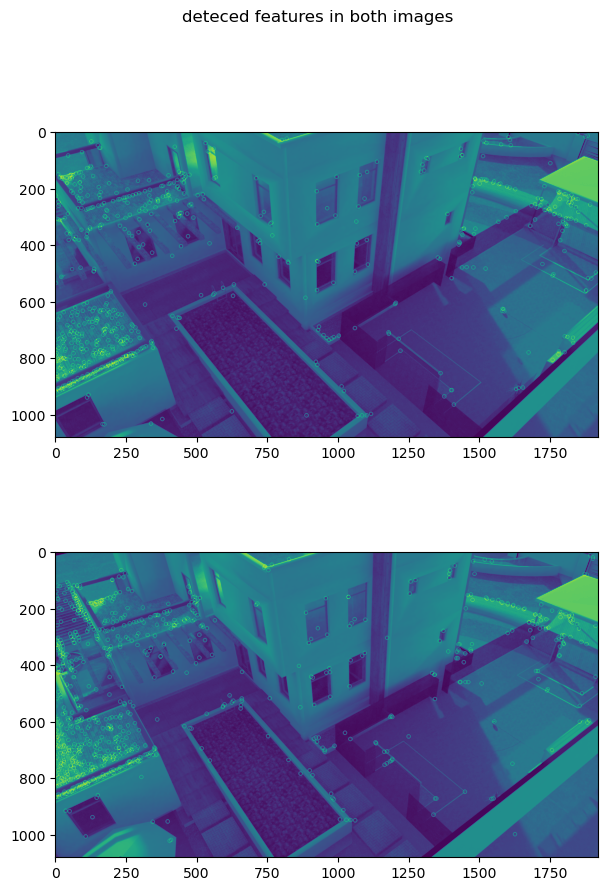

In [15]:
# 1. Detect keypoints and their descriptors
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# Initiate SIFT detector
# nOctaveLayers=3, contrastThreshold=0.07, edgeThreshold=4.5, sigma=2.0
# nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=4/3, sigma=1.6
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=4, sigma=1.6)
# orb = cv.ORB_create()
# first apply gaussian blur to eliminate the affect by low contrast features
# img1_blur = cv.GaussianBlur(img1, (5,5), cv.BORDER_DEFAULT)
# img2_blur = cv.GaussianBlur(img2, (5,5), cv.BORDER_DEFAULT)
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Visualize keypoints
img1_Sift = cv.drawKeypoints(
    img1, kp1, None, flags=4)
img2_Sift = cv.drawKeypoints(
    img2, kp2, None, flags=4)
img1_Sift = draw_keypoints(img1, kp1)
img2_Sift = draw_keypoints(img2, kp2)
plt.figure(figsize=(7, 10))
plt.subplot(211), plt.imshow(img1_Sift)
plt.subplot(212), plt.imshow(img2_Sift)
plt.suptitle("deteced features in both images")
# plt.savefig("sift_keypoints.png")
plt.show()

match points count 148


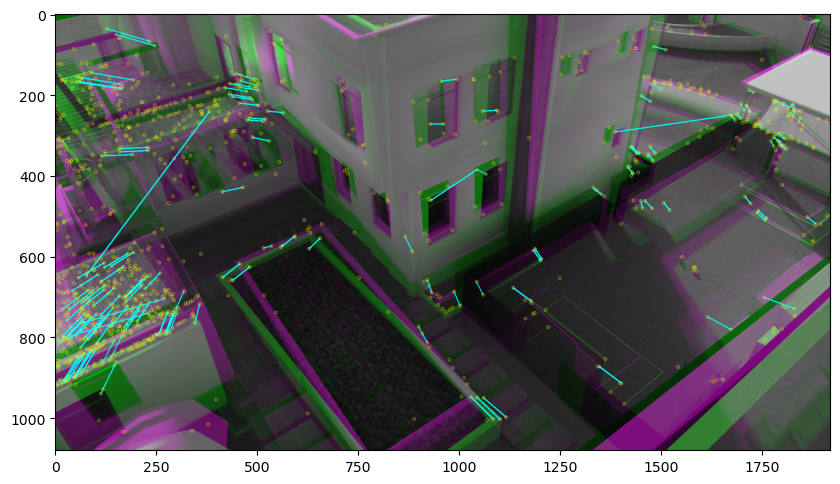

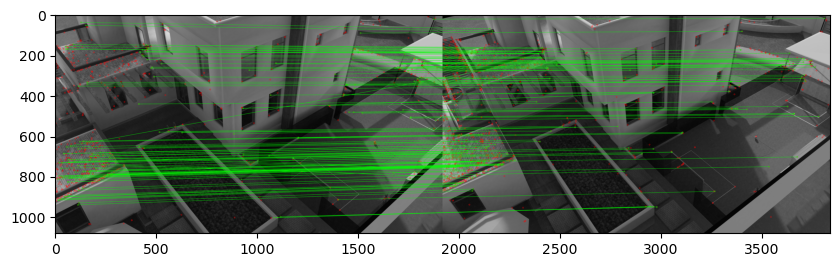

In [16]:
# 2. Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
# FLANN_INDEX_LSH = 6
# index_params= dict(algorithm = FLANN_INDEX_LSH,
#                    table_number = 6, # 12
#                    key_size = 12,     # 20
#                    multi_probe_level = 1) #2
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(np.asarray(des1, np.float32), np.asarray(des2, np.float32), k=2)
# matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

match_count = 0
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        match_count += 1
print("match points count %d" % match_count)

# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches, None, **draw_params)
comp_img = np.dstack((img2,img1,img2))
matched_comp_img = draw_composite_image(comp_img, matches, kp1=kp1, kp2=kp2, match_mask=matchesMask, num=10000)
plt.figure(figsize=(10, 7))
plt.imshow(matched_comp_img)
# plt.savefig('SIFT_match_img.jpg')
plt.show()
plt.figure(figsize=(10, 7))
plt.imshow(keypoint_matches)
# plt.savefig("keypoint_matches.png")

In [17]:
# 3.find fundamental matrix by camera configration
K = np.array([[1.600e+03, 0.000e+00, 9.595e+02],
                    [0.000e+00, 1.600e+03, 5.395e+02],
                    [0.000e+00, 0.000e+00, 1.000e+00]])
cam_1_ex = np.array([[-6.32422984e-01, -7.74574101e-01, 8.72639567e-03, -2.36433081e+00],
                    [-5.00836670e-01, 4.00276423e-01, -7.67425179e-01, -1.74806440e+00],
                    [ 5.90934694e-01, -4.89707828e-01, -6.41079128e-01, 2.59576015e+01],
                    [ 0., 0., 0., 1.]])
cam_1_dsto = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
K_p = np.array([[1.49333333e+03, 0.00000000e+00, 9.78700000e+02],
                    [0.00000000e+00, 1.49333333e+03, 5.20300000e+02],
                    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
cam_2_ex = np.array([[-0.5845883, -0.81050003, -0.03669427, -2.39520617],
                    [-0.5041514, 0.39832053, -0.76627171, -1.79913743],
                    [ 0.6356793, -0.42945388, -0.64146805, 26.26804151],
                    [ 0., 0., 0., 1.]])
cam_2_dsto = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
R = np.array([[ 0.9971792 , -0.00348069, 0.07497863],
            [ 0.00362138, 0.99999203, -0.00174044],
            [-0.07497205, 0.00200697, 0.99718366]])
T = np.array([[-1.98989457, 0.00265269, 0.20979508]]).T

# begin computing
frac1 = K_p @ T
frac2 = K_p @ R @ np.linalg.inv(K)
tmp1 = np.array([[0., -frac1[2][0], frac1[1][0]], 
                 [frac1[2][0], 0., -frac1[0][0]], 
                 [-frac1[1][0], frac1[0][0], 0.]])
F_cali = tmp1 @ frac2
F_cali = F_cali / F_cali[2][2]
print("fundmental matrix calculated by camera parameters:")
print(F_cali)

fundmental matrix calculated by camera parameters:
[[ 7.64315161e-09  1.67264739e-06 -9.48129529e-04]
 [-4.78516067e-07 -2.60194129e-08 -2.50407946e-02]
 [ 3.58785894e-04  2.20686928e-02  1.00000000e+00]]


fundmental matrix calculated by corresponding keypoints:
[[ 3.89089064e-08  4.00536765e-06 -2.76384306e-03]
 [-3.09433839e-06  3.18949251e-07 -1.84254639e-02]
 [ 2.15999210e-03  1.56538750e-02  1.00000000e+00]]


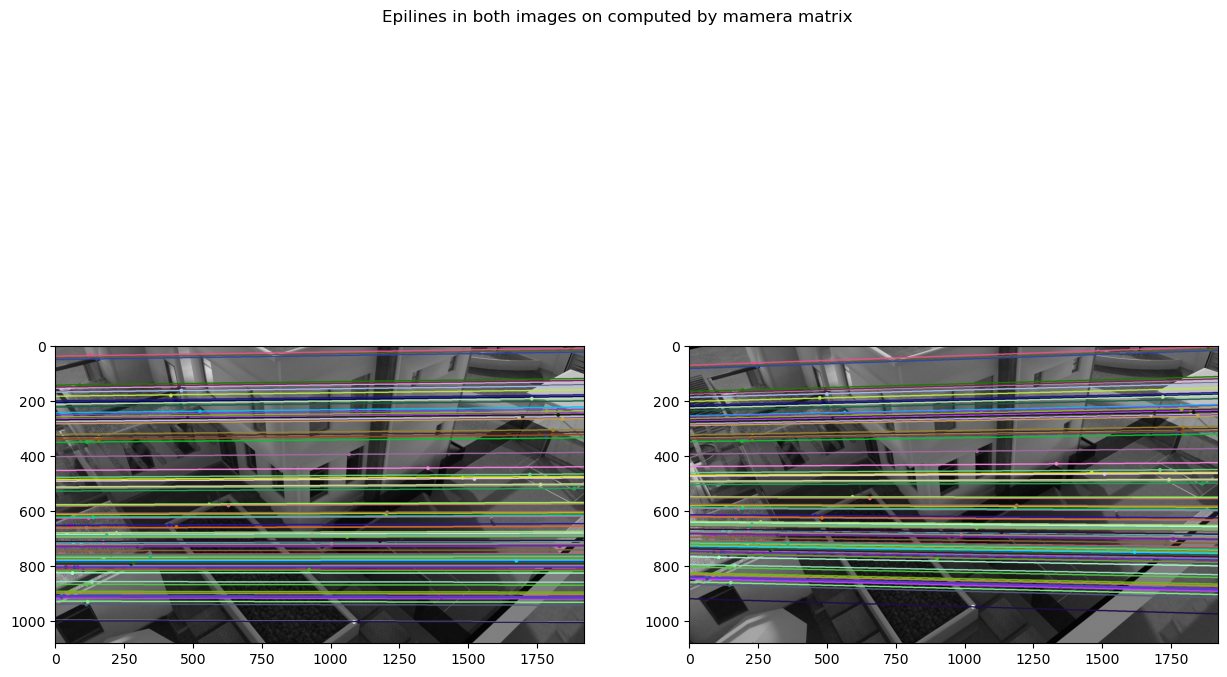

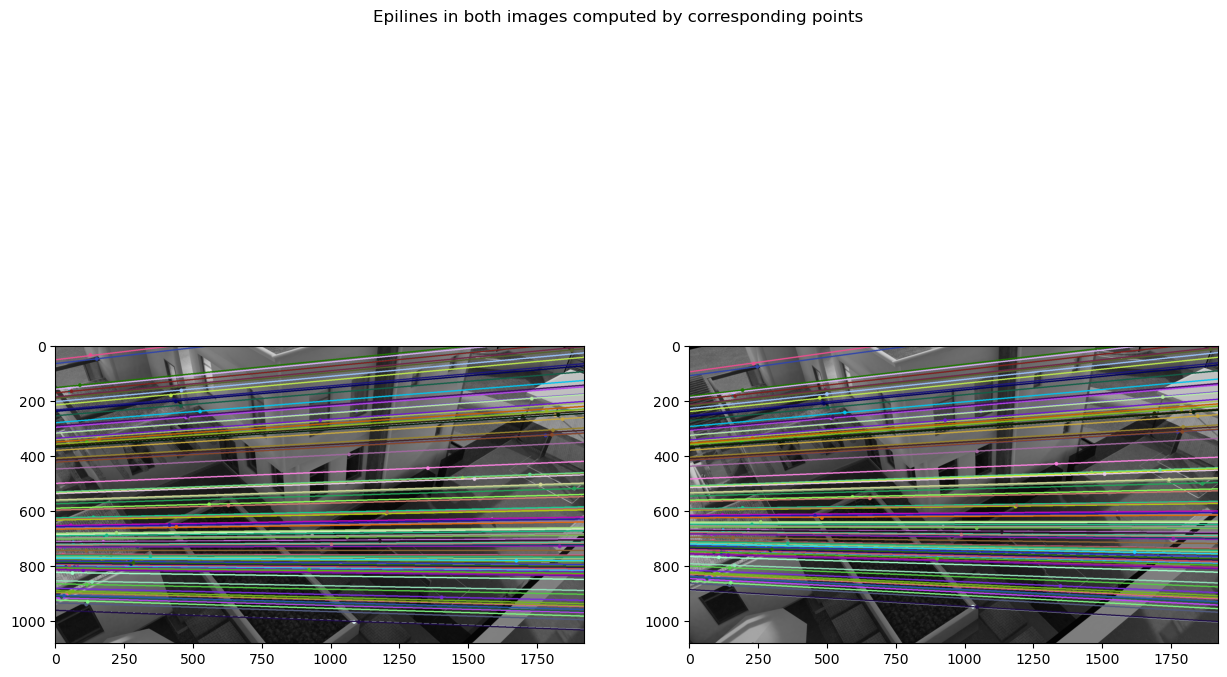

In [18]:
# 4. Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS) #cv.FM_RANSAC)
print("fundmental matrix calculated by corresponding keypoints:")
print(fundamental_matrix)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

# Find epilines corresponding to camera matrix
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, F_cali)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to camera matrix
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, F_cali)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)
plt.figure(figsize=(15, 10))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images on computed by mamera matrix")
plt.show()

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.figure(figsize=(15, 10))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images computed by corresponding points")
# plt.savefig("epilines.png")
plt.show()

maximum difference between two F is [[1.55830783e-08 6.99799786e-07 7.07866031e-04]
 [8.38828773e-07 6.31296885e-08 2.24897712e-03]
 [6.99636736e-04 2.13417241e-03 0.00000000e+00]]
0.039343954968339645


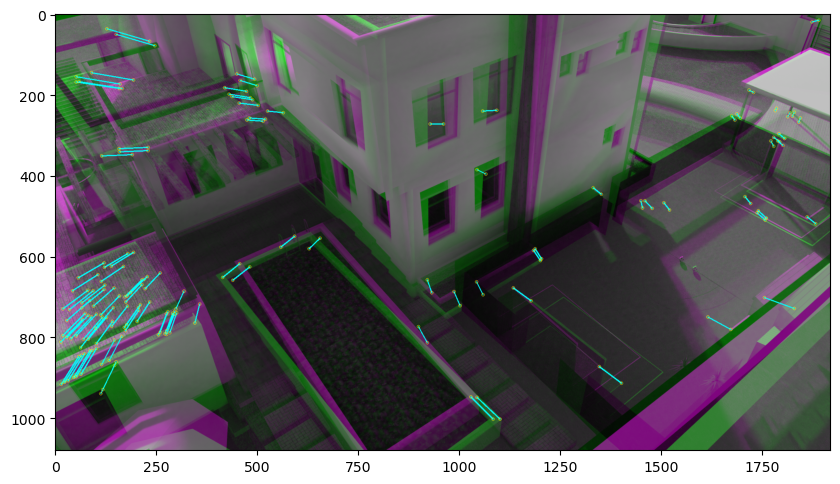

In [19]:
# compute how many points are on the lines
F_points = np.array([[ 2.32262299e-08,  2.37244718e-06, -1.65599556e-03],
         [-1.31734484e-06,  3.71102756e-08, -2.27918175e-02],
         [ 1.05842263e-03,  1.99345204e-02,  1.00000000e+00]])
# compute difference at each dimension
difference = np.abs(F_points - F_cali)
print("maximum difference between two F is", difference)
# compute x'Fx and set a threshold to see which keypoints are good
homo_pts1 = np.insert(pts1, 2, values=np.ones(pts1.shape[0]), axis=1)
homo_pts2 = np.insert(pts2, 2, values=np.ones(pts2.shape[0]), axis=1)
threshold = 0.01
inline_mapping_result = np.diagonal(homo_pts2 @ F_points @ homo_pts1.T)
print(max(inline_mapping_result))

# draw matched composite map
filtered_comp_img = draw_composite_matched_image(comp_img, pts1, pts2)
plt.figure(figsize=(10, 7))
plt.imshow(filtered_comp_img)
plt.savefig('SIFT_filtered_img_points.jpg')

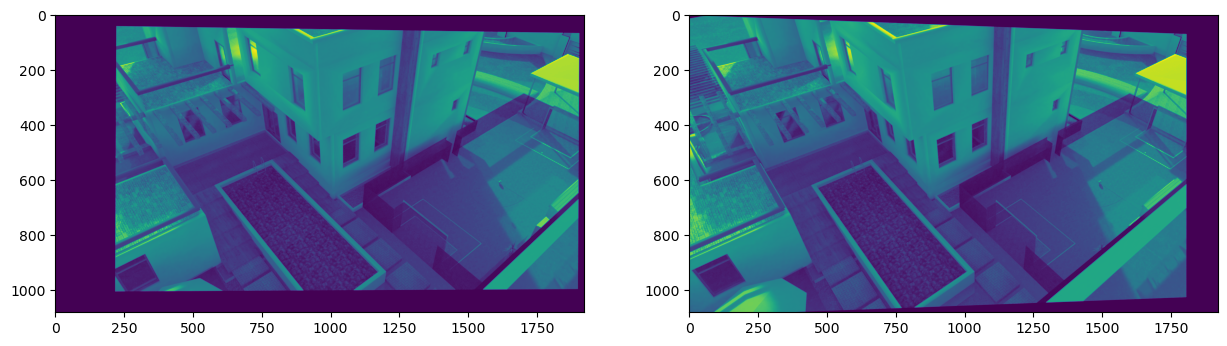

computing disparity...


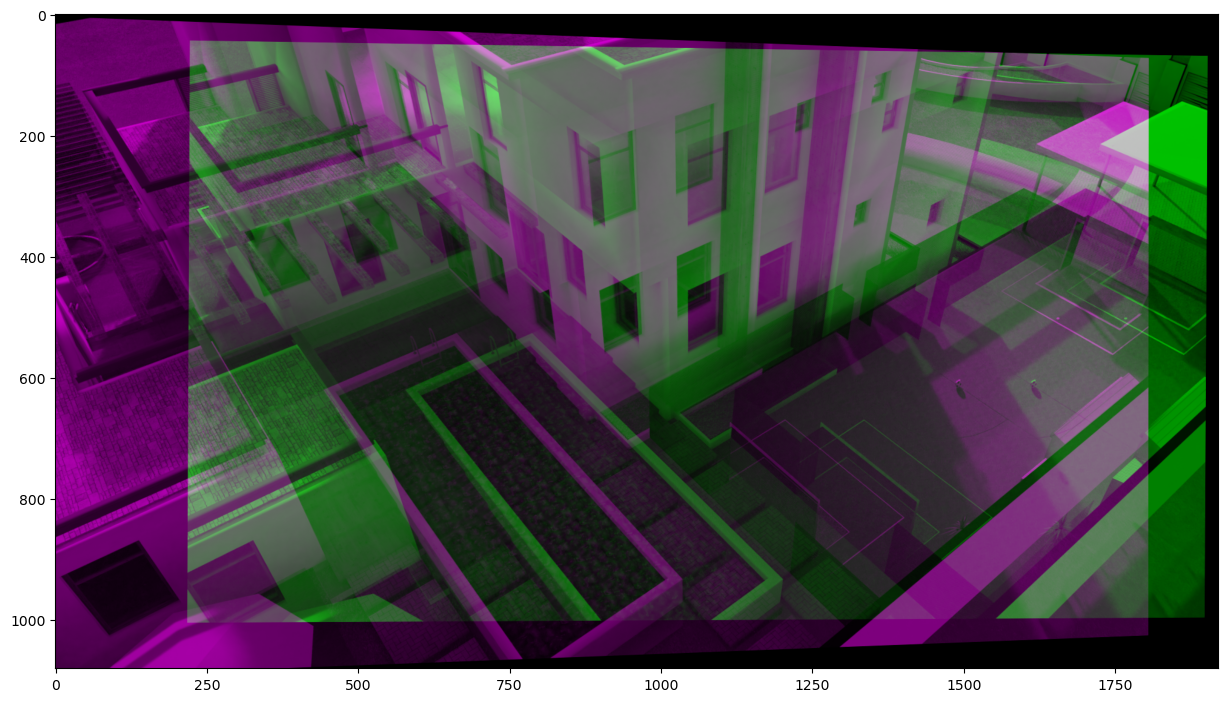

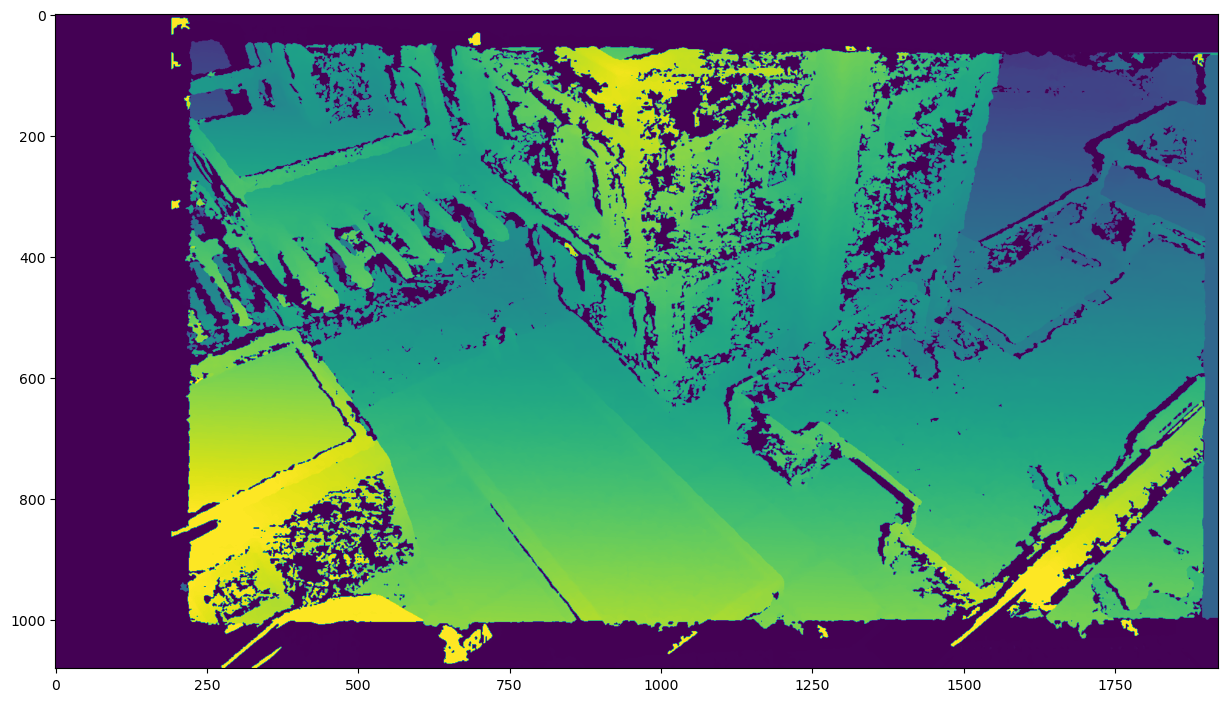

In [24]:
# 5.a rectify the image with camera matrix
height, width = img1.shape
R1, R2, P1, P2, Q, _, _ = cv.stereoRectify(K, cam_1_dsto, K_p, cam_2_dsto, (width, height), R, T, flags=cv.CALIB_ZERO_DISPARITY, alpha=0.9)
# R1 = R1.dot(np.linalg.inv(K))
# R2 = R2.dot(np.linalg.inv(K_p))
# rotate both images to have same position
leftMapX, leftMapY = cv.initUndistortRectifyMap(K, cam_1_dsto, R1, P1, (width, height), cv.CV_32FC1)
img1_rectified = cv.remap(img1, leftMapX, leftMapY, cv.INTER_LINEAR, cv.BORDER_CONSTANT)
img1_rectified_colored = cv.remap(img1_colored, leftMapX, leftMapY, cv.INTER_LINEAR, cv.BORDER_CONSTANT)
rightMapX, rightMapY = cv.initUndistortRectifyMap(K_p, cam_2_dsto, R2, P2, (width, height), cv.CV_32FC1)
img2_rectified = cv.remap(img2, rightMapX, rightMapY, cv.INTER_LINEAR, cv.BORDER_CONSTANT)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img1_rectified)
plt.subplot(122)
plt.imshow(img2_rectified)
plt.show()

comp_img = np.dstack((img2_rectified,img1_rectified,img2_rectified))
plt.figure(figsize=(15, 15))
plt.imshow(comp_img)
# plt.connect('motion_notify_event', mouse_move)
# plt.show()

# # compute disparity map
# stereo = cv.StereoBM_create(numDisparities=16, blockSize=5)
# disparity = stereo.compute(img_1_rectified, img_2_rectified)

# disparity range is tuned for 'aloe' image pair
window_size = 3
min_disp = 48
num_disp = 192 - min_disp
stereo = cv.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 7,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32
)

print('computing disparity...')
disparity = stereo.compute(img1_rectified, img2_rectified).astype(np.float32) / 16.0

plt.figure(figsize=(15,15))
# plt.figure()
plt.imshow(disparity)
# plt.colorbar()
plt.show()

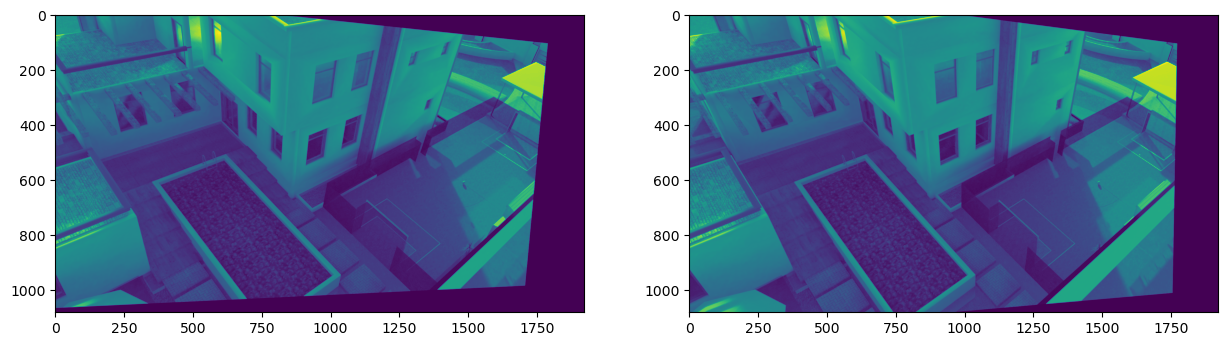

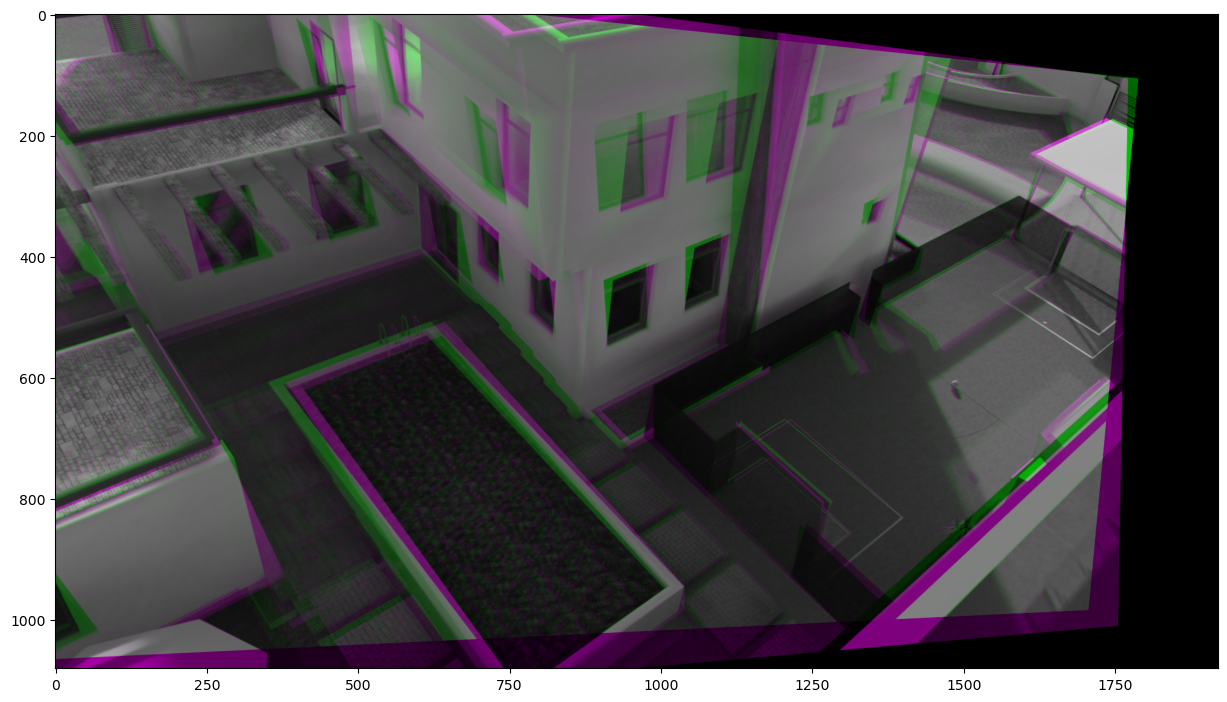

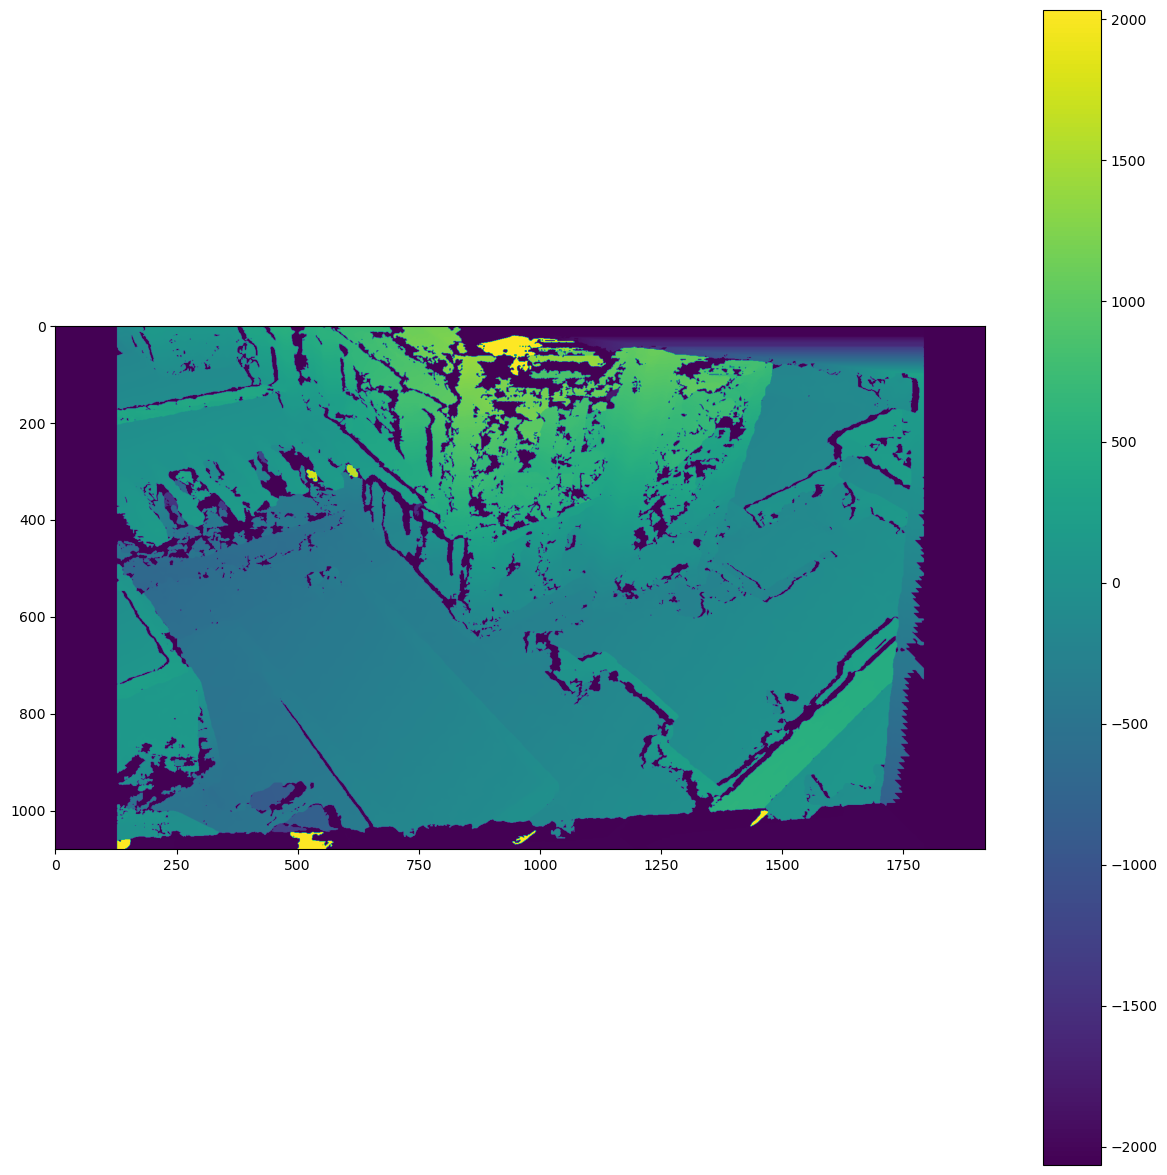

In [21]:
# 5.b rectify with computed fundamental matrix
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Rectify (undistort) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))

# Draw the rectified images
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img1_rectified)
plt.subplot(122)
plt.imshow(img2_rectified)
plt.show()

comp_img = np.dstack((img2_rectified,img1_rectified,img2_rectified))
plt.figure(figsize=(15, 15))
plt.imshow(comp_img)

# ------------------------------------------------------------
# CALCULATE DISPARITY (DEPTH MAP)
# Adapted from: https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py
# and: https://docs.opencv.org/master/dd/d53/tutorial_py_depthmap.html

# StereoSGBM Parameter explanations:
# https://docs.opencv.org/4.5.0/d2/d85/classcv_1_1StereoSGBM.html

# Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
block_size = 11
min_disp = -128
max_disp = 128
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 200
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disparity = stereo.compute(img1_rectified, img2_rectified)

plt.figure(figsize=(15,15))
plt.imshow(disparity)
plt.colorbar()
plt.show()

In [22]:
# 6. reconstruct 3d image
image_3d = cv.reprojectImageTo3D(disparity, Q)

# Get color points
colors = cv.cvtColor(img1_rectified_colored, cv.COLOR_BGR2RGB)

# Get rid of points with value 0 (i.e no depth)
mask_map = disparity > 0.0

# Mask colors and points. 
output_points = image_3d[mask_map]
output_colors = colors[mask_map]

# Define name for output file
# output_file = 'reconstructed_points.ply'
output_file = 'reconstructed_camera.ply'

# Generate point cloud 
print ("\n Creating the output file... \n")
create_output(output_file, output_points, output_colors)
print ("\n Finish creating! \n")


 Creating the output file... 


 Finish creating! 

